In [8]:
!pip install igraph


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import sys
import cv2 as cv
import igraph as ig
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [10]:
class GaussianMixture:
    def __init__(self, X, n_components=5): #X is FG or BG
        self.n_components = n_components
        self.n_features = X.shape[1]
        self.n_samples = np.zeros(self.n_components)
        self.coefs = np.zeros(self.n_components)
        self.means = np.zeros((self.n_components, self.n_features))
        self.covariances = np.zeros((self.n_components, self.n_features, self.n_features))
        self.init_with_kmeans(X) 

    def init_with_kmeans(self, X): #cluster FG or BG into n_components clusters using KMeans
        label = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
        self.fit(X, label)

    def calc_score(self, X, ci):
        score = np.zeros(X.shape[0])
        if self.coefs[ci] > 0:
            diff = X - self.means[ci]
            dist  = np.einsum('ij,ij->i', diff, np.dot(np.linalg.inv(self.covariances[ci]), diff.T).T) #Mahalanobis distance
            score = np.exp(-.5 * dist) / (np.sqrt(2 * np.pi)*np.sqrt(np.linalg.det(self.covariances[ci]))) #PDF of normal distribution
        return score

    def calc_prob(self, X):
        prob = [self.calc_score(X, ci) for ci in range(self.n_components)]
        return np.dot(self.coefs, prob)

    def which_component(self, X):
        prob = np.array([self.calc_score(X, ci)
                         for ci in range(self.n_components)]).T
        return np.argmax(prob, axis=1)

    def fit(self, X, labels):
        assert self.n_features == X.shape[1]
        self.n_samples[:] = 0
        self.coefs[:] = 0
        uni_labels, count = np.unique(labels, return_counts=True)
        self.n_samples[uni_labels] = count
        variance = 0.01
        for ci in uni_labels:
            n = self.n_samples[ci]
            self.coefs[ci] = n / np.sum(self.n_samples)
            self.means[ci] = np.mean(X[ci == labels], axis=0)
            self.covariances[ci] = 0 if self.n_samples[ci] <= 1 else np.cov(
                X[ci == labels].T)
            det = np.linalg.det(self.covariances[ci])
            if det <= 0:
                # Adds the white noise to avoid singular covariance matrix.
                self.covariances[ci] += np.eye(self.n_features) * variance
                det = np.linalg.det(self.covariances[ci])


if __name__ == '__main__':
    xx_list = np.array([[1.0, 3.0, 4],
                        [2.0, 3.0, 4],
                        [2.0, 3.5, 4],
                        [3, 4, 5],
                        [3.5, 4, 5],
                        [4, 5, 6],
                        [4, 5.5, 6],
                        [3, 6, 7]])
    center = np.array([[2.0, 3.0, 4.0], [4.0, 5.0, 6.0]])

    gmm = GaussianMixture(xx_list)
    print(gmm.which_component(np.array([[4, 5, 5]])))

#would not give the same result everytime because of the random initialization of KMeans centroids

[1]


In [11]:
print(gmm.calc_prob(np.array([[0, 0, 4]])))

[3.84614655e-103]


In [12]:
BLUE = [255, 0, 0]        # rectangle color
RED = [0, 0, 255]         # PR BG
GREEN = [0, 255, 0]       # PR FG
BLACK = [0, 0, 0]         # sure BG
WHITE = [255, 255, 255]   # sure FG

DRAW_BG = {'color': BLACK, 'val': 0}
DRAW_FG = {'color': WHITE, 'val': 1}
DRAW_PR_FG = {'color': GREEN, 'val': 3}
DRAW_PR_BG = {'color': RED, 'val': 2}

# setting up flags
rect = (0, 0, 1, 1)
drawing = False         # flag for drawing curves
rectangle = False       # flag for drawing rect
rect_over = False       # flag to check if rect drawn
rect_or_mask = 100      # flag for selecting rect or mask mode
value = DRAW_FG         # drawing initialized to FG
thickness = 3           # brush thickness
skip_learn_GMMs = False # whether to skip learning GMM parameters

def onmouse(event, x, y, flags, param):
    global img, img2, drawing, value, mask, rectangle, rect, rect_or_mask, ix, iy, rect_over, skip_learn_GMMs

    # --- Left Mouse Button for Rectangle Drawing ---
    if event == cv.EVENT_LBUTTONDOWN and not rect_over:
        rectangle = True
        ix, iy = x, y

    elif event == cv.EVENT_MOUSEMOVE and rectangle and not rect_over:
        img = img2.copy()
        cv.rectangle(img, (ix, iy), (x, y), BLUE, 2)
        rect = (min(ix, x), min(iy, y), abs(ix-x), abs(iy-y))
        rect_or_mask = 0

    elif event == cv.EVENT_LBUTTONUP and rectangle and not rect_over:
        rectangle = False
        rect_over = True
        cv.rectangle(img, (ix, iy), (x, y), BLUE, 2)
        rect = (min(ix, x), min(iy, y), abs(ix-x), abs(iy-y))
        rect_or_mask = 0
        print(" Now press the key 'n' a few times until no further change \n")

    # --- Left Mouse Button for Touchup Drawing (only after rectangle is over) ---
    elif event == cv.EVENT_LBUTTONDOWN and rect_over:
        drawing = True
        cv.circle(img, (x, y), thickness, value['color'], -1)
        cv.circle(mask, (x, y), thickness, value['val'], -1)

    elif event == cv.EVENT_MOUSEMOVE and drawing:
        cv.circle(img, (x, y), thickness, value['color'], -1)
        cv.circle(mask, (x, y), thickness, value['val'], -1)

    elif event == cv.EVENT_LBUTTONUP and drawing:
        drawing = False
        cv.circle(img, (x, y), thickness, value['color'], -1)
        cv.circle(mask, (x, y), thickness, value['val'], -1)
        skip_learn_GMMs = True


In [13]:
class GrabCut:
    def __init__(self, img, mask, rect=None, gmm_components=5):
        self.img = np.asarray(img, dtype=np.float64)
        self.rows, self.cols, _ = img.shape

        self.mask = mask
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3],
                      rect[0]:rect[0] + rect[2]] = DRAW_PR_FG['val']
        self.classify_pixels()

        # Best number of GMM components K suggested in paper
        self.gmm_components = gmm_components
        self.gamma = 50  # Best gamma suggested in paper formula (5)
        self.beta = 0

        self.left_B = np.empty((self.rows, self.cols - 1))
        self.upleft_B = np.empty((self.rows - 1, self.cols - 1))
        self.up_B = np.empty((self.rows - 1, self.cols))
        self.upright_B = np.empty((self.rows - 1, self.cols - 1))

        self.bgd_gmm = None
        self.fgd_gmm = None
        self.comp_idxs = np.empty((self.rows, self.cols), dtype=np.uint32)

        self.gc_graph = None
        self.gc_graph_capacity = None           # Edge capacities
        self.gc_source = self.cols * self.rows  # "object" terminal S
        self.gc_sink = self.gc_source + 1       # "background" terminal T

        self.calc_beta_smoothness()
        self.init_GMMs()
        self.run()

    def calc_beta_smoothness(self):
        _left_diff = self.img[:, 1:] - self.img[:, :-1]
        _upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1]
        _up_diff = self.img[1:, :] - self.img[:-1, :]
        _upright_diff = self.img[1:, :-1] - self.img[:-1, 1:]

        self.beta = np.sum(np.square(_left_diff)) + np.sum(np.square(_upleft_diff)) + \
            np.sum(np.square(_up_diff)) + \
            np.sum(np.square(_upright_diff))
        self.beta = 1 / (2 * self.beta / (
            # Each pixel has 4 neighbors (left, upleft, up, upright)
            4 * self.cols * self.rows
            # The 1st column doesn't have left, upleft and the last column doesn't have upright
            - 3 * self.cols
            - 3 * self.rows  # The first row doesn't have upleft, up and upright
            + 2))  # The first and last pixels in the 1st row are removed twice
        print('Beta:', self.beta)

        self.left_B = self.gamma * np.exp(-self.beta * np.sum(
            np.square(_left_diff), axis=2))
        self.upleft_B = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(
            np.square(_upleft_diff), axis=2))
        self.up_B = self.gamma * np.exp(-self.beta * np.sum(
            np.square(_up_diff), axis=2))
        self.upright_B = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(
            np.square(_upright_diff), axis=2))

    def classify_pixels(self):
        self.bgd_indexes = np.where(np.logical_or(
            self.mask == DRAW_BG['val'], self.mask == DRAW_PR_BG['val']))
        self.fgd_indexes = np.where(np.logical_or(
            self.mask == DRAW_FG['val'], self.mask == DRAW_PR_FG['val']))

        assert self.bgd_indexes[0].size > 0
        assert self.fgd_indexes[0].size > 0

        print('(pr_)bgd count: %d, (pr_)fgd count: %d' % (
            self.bgd_indexes[0].size, self.fgd_indexes[0].size))

    def init_GMMs(self):
        self.bgd_gmm = GaussianMixture(self.img[self.bgd_indexes])
        self.fgd_gmm = GaussianMixture(self.img[self.fgd_indexes])

    def assign_GMMs_components(self):
        
        self.comp_idxs[self.bgd_indexes] = self.bgd_gmm.which_component(
            self.img[self.bgd_indexes])
        self.comp_idxs[self.fgd_indexes] = self.fgd_gmm.which_component(
            self.img[self.fgd_indexes])

    def learn_GMMs(self):
       
        self.bgd_gmm.fit(self.img[self.bgd_indexes],
                         self.comp_idxs[self.bgd_indexes])
        self.fgd_gmm.fit(self.img[self.fgd_indexes],
                         self.comp_idxs[self.fgd_indexes])

    def construct_gc_graph(self):
        bgd_indexes = np.where(self.mask.reshape(-1) == DRAW_BG['val'])
        fgd_indexes = np.where(self.mask.reshape(-1) == DRAW_FG['val'])
        pr_indexes = np.where(np.logical_or(
            self.mask.reshape(-1) == DRAW_PR_BG['val'], self.mask.reshape(-1) == DRAW_PR_FG['val']))

        print('bgd count: %d, fgd count: %d, uncertain count: %d' % (
            len(bgd_indexes[0]), len(fgd_indexes[0]), len(pr_indexes[0])))

        edges = []
        self.gc_graph_capacity = []

        # t-links
        edges.extend(
            list(zip([self.gc_source] * pr_indexes[0].size, pr_indexes[0])))
        _D = -np.log(self.bgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * pr_indexes[0].size, pr_indexes[0])))
        _D = -np.log(self.fgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes]))
        self.gc_graph_capacity.extend(_D.tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_source] * bgd_indexes[0].size, bgd_indexes[0])))
        self.gc_graph_capacity.extend([0] * bgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * bgd_indexes[0].size, bgd_indexes[0])))
        self.gc_graph_capacity.extend([9 * self.gamma] * bgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_source] * fgd_indexes[0].size, fgd_indexes[0])))
        self.gc_graph_capacity.extend([9 * self.gamma] * fgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        edges.extend(
            list(zip([self.gc_sink] * fgd_indexes[0].size, fgd_indexes[0])))
        self.gc_graph_capacity.extend([0] * fgd_indexes[0].size)
        assert len(edges) == len(self.gc_graph_capacity)

        # print(len(edges))

        # n-links
        img_indexes = np.arange(self.rows * self.cols,
                                dtype=np.uint32).reshape(self.rows, self.cols)

        mask1 = img_indexes[:, 1:].reshape(-1)
        mask2 = img_indexes[:, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(self.left_B.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, 1:].reshape(-1)
        mask2 = img_indexes[:-1, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(
            self.upleft_B.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, :].reshape(-1)
        mask2 = img_indexes[:-1, :].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(self.up_B.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        mask1 = img_indexes[1:, :-1].reshape(-1)
        mask2 = img_indexes[:-1, 1:].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.gc_graph_capacity.extend(
            self.upright_B.reshape(-1).tolist())
        assert len(edges) == len(self.gc_graph_capacity)

        assert len(edges) == 4 * self.cols * self.rows - 3 * (self.cols + self.rows) + 2 + \
            2 * self.cols * self.rows

        self.gc_graph = ig.Graph(self.cols * self.rows + 2)
        self.gc_graph.add_edges(edges)

    def estimate_segmentation(self):
        """Step 3 in Figure 3: Estimate segmentation"""
        mincut = self.gc_graph.st_mincut(
            self.gc_source, self.gc_sink, self.gc_graph_capacity)
        print('foreground pixels: %d, background pixels: %d' % (
            len(mincut.partition[0]), len(mincut.partition[1])))
        pr_indexes = np.where(np.logical_or(
            self.mask == DRAW_PR_BG['val'], self.mask == DRAW_PR_FG['val']))
        img_indexes = np.arange(self.rows * self.cols,
                                dtype=np.uint32).reshape(self.rows, self.cols)
        self.mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),
                                         DRAW_PR_FG['val'], DRAW_PR_BG['val'])
        self.classify_pixels()

    def calc_energy(self):
        R = 0
        for ci in range(self.gmm_components):
            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(
                self.mask == DRAW_BG['val'], self.mask == DRAW_PR_BG['val'])))
            R += np.sum(-np.log(self.bgd_gmm.coefs[ci] * self.bgd_gmm.calc_score(self.img[idx], ci)))

            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(
                self.mask == DRAW_FG['val'], self.mask == DRAW_PR_FG['val'])))
            R += np.sum(-np.log(self.fgd_gmm.coefs[ci] * self.fgd_gmm.calc_score(self.img[idx], ci)))

        B = 0
        mask = self.mask.copy()
        mask[np.where(mask == DRAW_PR_BG['val'])] = DRAW_BG['val']
        mask[np.where(mask == DRAW_PR_FG['val'])] = DRAW_FG['val']

        B += np.sum(self.left_B * (mask[:, 1:] == mask[:, :-1]))
        B += np.sum(self.upleft_B * (mask[1:, 1:] == mask[:-1, :-1]))
        B += np.sum(self.up_B * (mask[1:, :] == mask[:-1, :]))
        B += np.sum(self.upright_B * (mask[1:, :-1] == mask[:-1, 1:]))
        return R, B, R + B

    def run(self, num_iters=1, skip_learn_GMMs=False):
        print('skip learn GMMs:', skip_learn_GMMs)
        for _ in range(num_iters):
            if not skip_learn_GMMs:
                self.assign_GMMs_components()
                self.learn_GMMs()
            self.construct_gc_graph()
            self.estimate_segmentation()
            skip_learn_GMMs = False
            # print('data term: %f, smoothness term: %f, total energy: %f' % self.calc_energy())

 Instructions: 

 Draw a rectangle around the object using right mouse button 

 Now press the key 'n' a few times until no further change 

 For finer touchups, mark foreground and background after pressing keys 0-3
            and again press 'n' 

(60, 92, 287, 268)
(pr_)bgd count: 119692, (pr_)fgd count: 76916
Beta: 0.0005531262752889795
skip learn GMMs: False
bgd count: 119692, fgd count: 0, uncertain count: 76916
foreground pixels: 38196, background pixels: 158414
(pr_)bgd count: 158413, (pr_)fgd count: 38195
 mark background regions with left mouse button 

 mark background regions with left mouse button 

 For finer touchups, mark foreground and background after pressing keys 0-3
            and again press 'n' 

(60, 92, 287, 268)
skip learn GMMs: True
bgd count: 124006, fgd count: 0, uncertain count: 72602
foreground pixels: 31051, background pixels: 165559
(pr_)bgd count: 165558, (pr_)fgd count: 31050


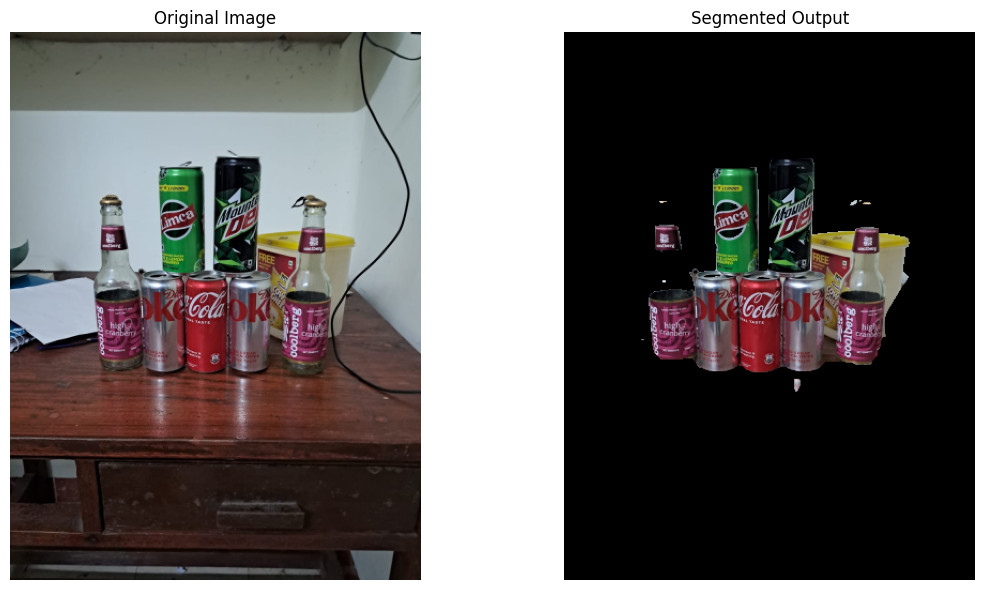

In [14]:
if __name__ == '__main__':

    filename=r"C:\Users\deban\Desktop\6th Sem\DVP\TPA\WhatsApp Image 2025-05-21 at 6.59.08 PM.jpeg"
    img = cv.imread(filename)
    scale_percent = 40  # shrink to 40% of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    img = cv.resize(img, dim, interpolation=cv.INTER_AREA)
    img2 = img.copy()
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    output = np.zeros(img.shape, np.uint8)


    # input and output windows
    cv.namedWindow('output')
    cv.namedWindow('input')
    cv.setMouseCallback('input', onmouse)
    cv.moveWindow('input', img.shape[1]+10, 90)

    print(" Instructions: \n")
    print(" Draw a rectangle around the object using right mouse button \n")

    while(1):

        cv.imshow('output', output)
        cv.imshow('input', img)
        k = cv.waitKey(1)

        # key bindings
        if k == 27:  # esc to exit

            img_rgb = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
            output_rgb = cv.cvtColor(output, cv.COLOR_BGR2RGB)

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(output_rgb)
            plt.title("Segmented Output")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            break

        elif k == ord('0'):  # BG drawing
            print(" mark background regions with left mouse button \n")
            value = DRAW_BG
        elif k == ord('1'):  # FG drawing
            print(" mark foreground regions with left mouse button \n")
            value = DRAW_FG
        elif k == ord('2'):  # PR_BG drawing
            value = DRAW_PR_BG
        elif k == ord('3'):  # PR_FG drawing
            value = DRAW_PR_FG
        elif k == ord('s'):  # save image
            bar = np.zeros((img.shape[0], 5, 3), np.uint8)
            res = np.hstack((img2, bar, img, bar, output))
            cv.imwrite('grabcut_output.png', res)
            print(" Result saved as image \n")
        elif k == ord('r'):  # reset everything
            print("resetting \n")
            rect = (0, 0, 1, 1)
            drawing = False
            rectangle = False
            rect_or_mask = 100
            rect_over = False
            value = DRAW_FG
            img = img2.copy()
            # mask initialized to PR_BG
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            # output image to be shown
            output = np.zeros(img.shape, np.uint8)
        elif k == ord('n'):  # segment the image
            print(""" For finer touchups, mark foreground and background after pressing keys 0-3
            and again press 'n' \n""")
            print(rect)
            if (rect_or_mask == 0):         # grabcut with rect
                gc = GrabCut(img2, mask, rect)
                rect_or_mask = 1
            elif rect_or_mask == 1:         # grabcut with mask
                gc.run(skip_learn_GMMs=skip_learn_GMMs)
                skip_learn_GMMs = False

        mask2 = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        output = cv.bitwise_and(img2, img2, mask=mask2)

    cv.destroyAllWindows()